## GNN

### Подготовка к работе

In [2]:
! pip install biopandas

In [3]:
import numpy as np
import torch
from biopandas.pdb import PandasPdb
from itertools import combinations
from torch_geometric.data import Data

/home/paa/Develop/biocadprotein/.venv/lib64/python3/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Подготовка данных

In [4]:
def pdb_to_pyg_graph(pdb_file: str, target: float, distance_threshold: float = 3.0) -> Data:
    ppdb = PandasPdb().read_pdb(pdb_file)
    atoms = ppdb.df['ATOM']

    # Группировка атомов по остатку (chain_id, residue_number)
    atoms['res_id'] = atoms['chain_id'].astype(str) + "_" + atoms['residue_number'].astype(str)
    residue_groups = atoms.groupby('res_id')

    residues = list(residue_groups.groups.keys())
    num_nodes = len(residues)

    # Собираем координаты и имена остатков
    residue_coords = []
    residue_names = []

    for res_id in residues:
        group = residue_groups.get_group(res_id)
        coords = group[['x_coord', 'y_coord', 'z_coord']].values
        residue_coords.append(coords)
        residue_names.append(group['residue_name'].values[0])  # Одно имя на остаток

    # One-hot кодировка аминокислот
    aa_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
               'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
               'TYR', 'VAL']
    aa_to_idx = {aa: i for i, aa in enumerate(aa_list)}
    aa_indices = [aa_to_idx.get(res, len(aa_list)) for res in residue_names]
    one_hot = np.zeros((num_nodes, len(aa_list)+1))  # +1 для unknown
    one_hot[np.arange(num_nodes), aa_indices] = 1

    # В качестве координат узла можно взять центр масс или просто среднее
    centers = np.array([coords.mean(axis=0) for coords in residue_coords])

    # Узловые признаки: средние координаты + one-hot кодировка
    x = torch.tensor(np.concatenate([centers, one_hot], axis=1), dtype=torch.float)

    # Построение рёбер: расстояние между всеми парами остатков по минимальному расстоянию между атомами
    edge_index = []
    edge_attr = []

    for i, j in combinations(range(num_nodes), 2):
        coords_i = residue_coords[i]
        coords_j = residue_coords[j]

        dists = np.linalg.norm(coords_i[:, None, :] - coords_j[None, :, :], axis=2)
        min_dist = np.min(dists)

        if min_dist <= distance_threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])
            edge_attr.append([min_dist])
            edge_attr.append([min_dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [5]:
graph = pdb_to_pyg_graph("/home/paa/Develop/biocadprotein/data/archive/pdb_active_sites/radius_8/1AFJZ.pdb", 1.843934)
graph.get_edge_index

<bound method GraphStore.get_edge_index of Data(x=[127, 24], edge_index=[2, 398], edge_attr=[398, 1], y=[1])>

In [6]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_pyg_graph(data, dim=2, node_label_attr='residue_name'):
    # Преобразуем PyG Data в NetworkX граф
    G = to_networkx(data, to_undirected=True)

    # Координаты узлов для отрисовки
    if dim == 2:
        pos = {i: (data.x[i][0].item(), data.x[i][1].item()) for i in range(data.num_nodes)}
    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for i, (xi, yi, zi) in enumerate(data.x[:, :3]):
            ax.scatter(xi, yi, zi, color='skyblue')
            ax.text(xi, yi, zi, str(i), size=6)
        for i, j in data.edge_index.T:
            xi, yi, zi = data.x[i][:3]
            xj, yj, zj = data.x[j][:3]
            ax.plot([xi, xj], [yi, yj], [zi, zj], color='gray', alpha=0.5)
        ax.set_title(f"3D Graph: {getattr(data, 'protein_name', '')}")
        plt.show()
        return

    # 2D-граф через networkx
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color='lightblue', edge_color='gray', with_labels=False, node_size=300)
    plt.title(f"2D Projection of Graph: {getattr(data, 'protein_name', '')}")
    plt.show()

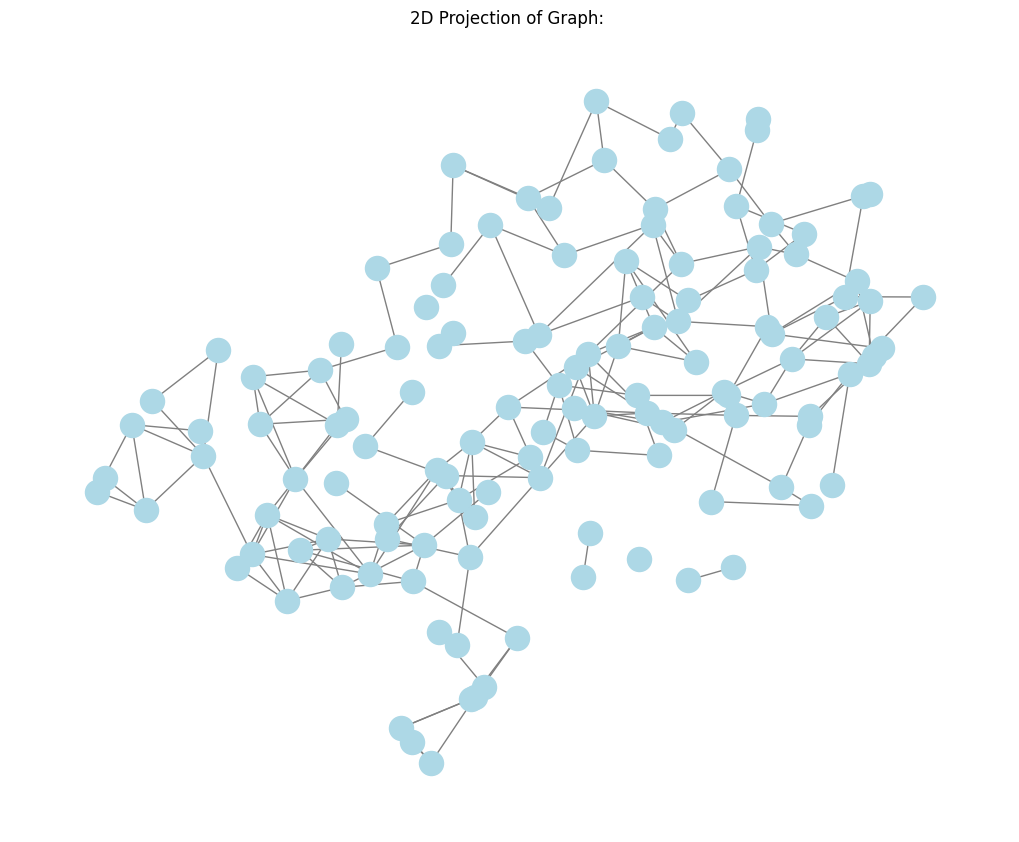

In [7]:
visualize_pyg_graph(graph)

In [21]:
from fpgen.prop_prediction.dataset import FPbase

In [22]:
dataset = FPbase('../data/dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/dataset.csv'

In [10]:
x_train, y_train = dataset.get_train('em_max', additional_feature_columns=['id'])
x_test, y_test = dataset.get_test('em_max', additional_feature_columns=['id'])

In [11]:
path = '/home/paa/Develop/biocadprotein/data/archive/pdb_active_sites/radius_8/'

def preprocessing_dataset(x, y):
    graph = []
    for i in range(len(x)):
        id = x.iloc[i]['id']
        if id != '7XHKJ':
            g = pdb_to_pyg_graph(f'{path}{id}.pdb', y[i])
            graph.append(g)
    return graph

In [12]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(preprocessing_dataset(x_train, y_train), test_size=0.2, random_state=52)
test = preprocessing_dataset(x_test, y_test)

In [13]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=False)
val_loader = DataLoader(val, batch_size=16, shuffle=False)

/home/paa/Develop/biocadprotein/.venv/lib64/python3/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Архитектура модели

In [14]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, Sequential, ReLU
from torch_geometric.nn import GINEConv, global_add_pool
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.data import Data

class GNN(torch.nn.Module):
    """
    GNN для предсказания одного спектрального параметра
    (например, brightness) по структуре белка.
    """
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4):
        super().__init__()

        self.num_gaussians = 32
        self.register_buffer('offsets', torch.linspace(0, 10, self.num_gaussians))
        self.register_buffer('widths', torch.full((self.num_gaussians,), 0.5))

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = ModuleList()
        self.norms = ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )
            conv = GINEConv(mlp, edge_dim=self.num_gaussians)
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim))

        # Один выходной нейрон — регрессия
        self.head = Sequential(
            Linear(hidden_dim, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)  # ⬅️ только один выход
        )

    def gaussian_smearing(self, distances: torch.Tensor) -> torch.Tensor:
        diff = distances.unsqueeze(1) - self.offsets.unsqueeze(0)
        return torch.exp(-0.5 * (diff / self.widths.unsqueeze(0)) ** 2)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.squeeze()
        x = self.node_embed(x)
        edge_emb = self.gaussian_smearing(edge_attr)

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_emb)
            x = norm(x)
            x = F.relu(x)

        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)  # [batch_size, 1]
        return out.squeeze(-1)  # ⬅️ делаем [batch_size] для удобства


In [15]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import MessagePassing, GraphNorm, global_add_pool
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops


class GaussianMP(MessagePassing):
    def __init__(self, hidden_dim: int, edge_dim: int):
        super().__init__(aggr='add')  # можно 'mean' или 'max' при желании
        self.mlp = Sequential(
            Linear(hidden_dim + edge_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        # MessagePassing expects edge_index to be [2, num_edges]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of neighbors
        msg_input = torch.cat([x_j, edge_attr], dim=-1)
        return self.mlp(msg_input)

    def update(self, aggr_out):
        return aggr_out  # можно вставить нормализацию или residual


class GNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4):
        super().__init__()

        self.num_gaussians = 32
        self.register_buffer('offsets', torch.linspace(0, 10, self.num_gaussians))
        self.register_buffer('widths', torch.full((self.num_gaussians,), 0.5))

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(num_layers):
            conv = GaussianMP(hidden_dim=hidden_dim, edge_dim=self.num_gaussians)
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim))

        self.head = Sequential(
            Linear(hidden_dim, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)
        )

    def gaussian_smearing(self, distances: torch.Tensor) -> torch.Tensor:
        diff = distances.unsqueeze(1) - self.offsets.unsqueeze(0)
        return torch.exp(-0.5 * (diff / self.widths.unsqueeze(0)) ** 2)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.squeeze()
        x = self.node_embed(x)
        edge_emb = self.gaussian_smearing(edge_attr)

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_emb)
            x = norm(x)
            x = F.relu(x)

        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)
        return out.squeeze(-1)

### Обучение модели

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN(in_channels=24).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()  # так как регрессия

In [17]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        '''
        print("x:", data.x.shape)
        print("y:", data.y.shape)
        print("batch:", data.batch.shape)
        '''
        target = data.y.view(-1)

        optimizer.zero_grad()
        out = model(data)  # [batch_size, 6]
        #print(out.shape)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [18]:
def evaluate(model, loader, return_preds=False):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  # [batch_size]
            target = data.y.squeeze()  # Убедись, что размерности совпадают
            loss = loss_fn(out, target)
            total_loss += loss.item()

            if return_preds:
                all_preds.append(out.cpu())
                all_targets.append(target.cpu())

    if return_preds:
        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_targets).numpy()
        return y_pred, y_true

    return total_loss / len(loader)


In [19]:
from tqdm import tqdm

best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(100)):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]/home/paa/Develop/biocadprotein/.venv/lib64/python3/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:06<10:21,  6.28s/it]

Epoch 0 | Train Loss: 5.0662 | Val Loss: 1.1059


  2%|▏         | 2/100 [00:11<09:28,  5.80s/it]

Epoch 1 | Train Loss: 0.9398 | Val Loss: 1.2135


  3%|▎         | 3/100 [00:17<09:05,  5.63s/it]

Epoch 2 | Train Loss: 0.9219 | Val Loss: 0.8891


  4%|▍         | 4/100 [00:22<08:57,  5.60s/it]

Epoch 3 | Train Loss: 1.0592 | Val Loss: 0.8969


  5%|▌         | 5/100 [00:28<09:03,  5.72s/it]

Epoch 4 | Train Loss: 1.0192 | Val Loss: 0.6436


  6%|▌         | 6/100 [00:34<08:55,  5.69s/it]

Epoch 5 | Train Loss: 1.0335 | Val Loss: 0.8897


  7%|▋         | 7/100 [00:40<08:52,  5.73s/it]

Epoch 6 | Train Loss: 1.2374 | Val Loss: 0.7304


  8%|▊         | 8/100 [00:46<09:02,  5.90s/it]

Epoch 7 | Train Loss: 0.6479 | Val Loss: 0.7609


  9%|▉         | 9/100 [00:52<09:05,  5.99s/it]

Epoch 8 | Train Loss: 0.6442 | Val Loss: 0.7284


 10%|█         | 10/100 [00:58<09:01,  6.01s/it]

Epoch 9 | Train Loss: 0.6381 | Val Loss: 0.6945


 11%|█         | 11/100 [01:04<08:52,  5.99s/it]

Epoch 10 | Train Loss: 0.6011 | Val Loss: 0.7740


 12%|█▏        | 12/100 [01:10<08:49,  6.02s/it]

Epoch 11 | Train Loss: 0.5998 | Val Loss: 0.6935


 13%|█▎        | 13/100 [01:16<08:32,  5.89s/it]

Epoch 12 | Train Loss: 0.6415 | Val Loss: 0.6728


 14%|█▍        | 14/100 [01:22<08:23,  5.86s/it]

Epoch 13 | Train Loss: 0.6461 | Val Loss: 0.9999


 15%|█▌        | 15/100 [01:28<08:22,  5.91s/it]

Epoch 14 | Train Loss: 0.6298 | Val Loss: 0.8775


 16%|█▌        | 16/100 [01:33<08:15,  5.90s/it]

Epoch 15 | Train Loss: 0.7023 | Val Loss: 0.7204


 17%|█▋        | 17/100 [01:39<08:04,  5.84s/it]

Epoch 16 | Train Loss: 0.6049 | Val Loss: 0.7701


 18%|█▊        | 18/100 [01:45<07:55,  5.80s/it]

Epoch 17 | Train Loss: 0.5052 | Val Loss: 0.6320


 19%|█▉        | 19/100 [01:50<07:45,  5.75s/it]

Epoch 18 | Train Loss: 0.4804 | Val Loss: 0.7046


 20%|██        | 20/100 [01:56<07:36,  5.71s/it]

Epoch 19 | Train Loss: 0.5595 | Val Loss: 0.8193


 21%|██        | 21/100 [02:02<07:34,  5.75s/it]

Epoch 20 | Train Loss: 0.6982 | Val Loss: 0.6654


 22%|██▏       | 22/100 [02:08<07:34,  5.83s/it]

Epoch 21 | Train Loss: 0.5695 | Val Loss: 0.7307


 23%|██▎       | 23/100 [02:14<07:30,  5.85s/it]

Epoch 22 | Train Loss: 0.5203 | Val Loss: 0.7948


 24%|██▍       | 24/100 [02:20<07:33,  5.97s/it]

Epoch 23 | Train Loss: 0.5012 | Val Loss: 0.9049


 25%|██▌       | 25/100 [02:26<07:25,  5.94s/it]

Epoch 24 | Train Loss: 0.4403 | Val Loss: 0.7694


 26%|██▌       | 26/100 [02:32<07:16,  5.90s/it]

Epoch 25 | Train Loss: 0.4296 | Val Loss: 0.6318


 27%|██▋       | 27/100 [02:38<07:08,  5.88s/it]

Epoch 26 | Train Loss: 0.3505 | Val Loss: 0.6805


 28%|██▊       | 28/100 [02:43<06:59,  5.83s/it]

Epoch 27 | Train Loss: 0.3510 | Val Loss: 0.8060


 29%|██▉       | 29/100 [02:49<06:53,  5.82s/it]

Epoch 28 | Train Loss: 0.3574 | Val Loss: 0.6588


 30%|███       | 30/100 [02:55<06:45,  5.80s/it]

Epoch 29 | Train Loss: 0.3273 | Val Loss: 0.9798


 31%|███       | 31/100 [03:01<06:37,  5.77s/it]

Epoch 30 | Train Loss: 0.3578 | Val Loss: 0.6414


 32%|███▏      | 32/100 [03:06<06:31,  5.76s/it]

Epoch 31 | Train Loss: 0.3213 | Val Loss: 0.6330


 33%|███▎      | 33/100 [03:12<06:26,  5.77s/it]

Epoch 32 | Train Loss: 0.2663 | Val Loss: 0.7946


 34%|███▍      | 34/100 [03:18<06:26,  5.86s/it]

Epoch 33 | Train Loss: 0.2922 | Val Loss: 0.7926


 35%|███▌      | 35/100 [03:24<06:24,  5.91s/it]

Epoch 34 | Train Loss: 0.3072 | Val Loss: 0.8242


 36%|███▌      | 36/100 [03:30<06:22,  5.98s/it]

Epoch 35 | Train Loss: 0.3217 | Val Loss: 0.6972


 37%|███▋      | 37/100 [03:36<06:18,  6.01s/it]

Epoch 36 | Train Loss: 0.3917 | Val Loss: 0.8958


 38%|███▊      | 38/100 [03:43<06:15,  6.06s/it]

Epoch 37 | Train Loss: 0.3961 | Val Loss: 0.8617


 39%|███▉      | 39/100 [03:49<06:12,  6.11s/it]

Epoch 38 | Train Loss: 0.2957 | Val Loss: 0.7514


 40%|████      | 40/100 [03:55<06:06,  6.11s/it]

Epoch 39 | Train Loss: 0.3423 | Val Loss: 0.7823


 41%|████      | 41/100 [04:01<06:04,  6.18s/it]

Epoch 40 | Train Loss: 0.2920 | Val Loss: 0.8132


 42%|████▏     | 42/100 [04:07<05:54,  6.10s/it]

Epoch 41 | Train Loss: 0.2461 | Val Loss: 0.6611


 43%|████▎     | 43/100 [04:13<05:49,  6.12s/it]

Epoch 42 | Train Loss: 0.3164 | Val Loss: 0.7956


 44%|████▍     | 44/100 [04:20<06:00,  6.44s/it]

Epoch 43 | Train Loss: 0.3051 | Val Loss: 0.6554


 45%|████▌     | 45/100 [04:29<06:20,  6.91s/it]

Epoch 44 | Train Loss: 0.3190 | Val Loss: 0.6783


 46%|████▌     | 46/100 [04:36<06:26,  7.16s/it]

Epoch 45 | Train Loss: 0.3592 | Val Loss: 0.6369


 47%|████▋     | 47/100 [04:44<06:33,  7.43s/it]

Epoch 46 | Train Loss: 0.3327 | Val Loss: 0.6493


 48%|████▊     | 48/100 [04:52<06:36,  7.62s/it]

Epoch 47 | Train Loss: 0.2777 | Val Loss: 0.8402


 49%|████▉     | 49/100 [05:01<06:39,  7.83s/it]

Epoch 48 | Train Loss: 0.3495 | Val Loss: 0.6413


 50%|█████     | 50/100 [05:09<06:42,  8.06s/it]

Epoch 49 | Train Loss: 0.2558 | Val Loss: 0.6997


 51%|█████     | 51/100 [05:17<06:36,  8.10s/it]

Epoch 50 | Train Loss: 0.1986 | Val Loss: 0.5371


 52%|█████▏    | 52/100 [05:26<06:30,  8.13s/it]

Epoch 51 | Train Loss: 0.1770 | Val Loss: 0.5970


 53%|█████▎    | 53/100 [05:34<06:27,  8.25s/it]

Epoch 52 | Train Loss: 0.1848 | Val Loss: 0.5458


 54%|█████▍    | 54/100 [05:43<06:25,  8.39s/it]

Epoch 53 | Train Loss: 0.2176 | Val Loss: 0.6083


 55%|█████▌    | 55/100 [05:52<06:20,  8.45s/it]

Epoch 54 | Train Loss: 0.2181 | Val Loss: 0.5585


 56%|█████▌    | 56/100 [06:00<06:14,  8.52s/it]

Epoch 55 | Train Loss: 0.2323 | Val Loss: 0.5506


 57%|█████▋    | 57/100 [06:09<06:06,  8.52s/it]

Epoch 56 | Train Loss: 0.2857 | Val Loss: 0.6172


 58%|█████▊    | 58/100 [06:17<06:00,  8.59s/it]

Epoch 57 | Train Loss: 0.2058 | Val Loss: 0.5539


 59%|█████▉    | 59/100 [06:26<05:50,  8.54s/it]

Epoch 58 | Train Loss: 0.2164 | Val Loss: 0.6003


 60%|██████    | 60/100 [06:34<05:39,  8.48s/it]

Epoch 59 | Train Loss: 0.1778 | Val Loss: 0.6470


 61%|██████    | 61/100 [06:43<05:28,  8.42s/it]

Epoch 60 | Train Loss: 0.1952 | Val Loss: 0.6254


 62%|██████▏   | 62/100 [06:51<05:17,  8.37s/it]

Epoch 61 | Train Loss: 0.2708 | Val Loss: 0.5408


 63%|██████▎   | 63/100 [06:59<05:09,  8.37s/it]

Epoch 62 | Train Loss: 0.2147 | Val Loss: 0.6491


 64%|██████▍   | 64/100 [07:08<05:07,  8.54s/it]

Epoch 63 | Train Loss: 0.2592 | Val Loss: 0.5285


 65%|██████▌   | 65/100 [07:17<04:58,  8.53s/it]

Epoch 64 | Train Loss: 0.1840 | Val Loss: 0.5271


 66%|██████▌   | 66/100 [07:25<04:53,  8.64s/it]

Epoch 65 | Train Loss: 0.1726 | Val Loss: 0.5532


 67%|██████▋   | 67/100 [07:35<04:50,  8.80s/it]

Epoch 66 | Train Loss: 0.1498 | Val Loss: 0.5895


 68%|██████▊   | 68/100 [07:44<04:42,  8.82s/it]

Epoch 67 | Train Loss: 0.1618 | Val Loss: 0.4959


 69%|██████▉   | 69/100 [07:52<04:34,  8.84s/it]

Epoch 68 | Train Loss: 0.1523 | Val Loss: 0.5193


 70%|███████   | 70/100 [08:01<04:20,  8.68s/it]

Epoch 69 | Train Loss: 0.1745 | Val Loss: 0.5507


 71%|███████   | 71/100 [08:09<04:08,  8.57s/it]

Epoch 70 | Train Loss: 0.2823 | Val Loss: 0.5637


 72%|███████▏  | 72/100 [08:17<03:57,  8.50s/it]

Epoch 71 | Train Loss: 0.2113 | Val Loss: 0.4982


 73%|███████▎  | 73/100 [08:26<03:49,  8.48s/it]

Epoch 72 | Train Loss: 0.3908 | Val Loss: 0.6668


 74%|███████▍  | 74/100 [08:34<03:40,  8.49s/it]

Epoch 73 | Train Loss: 0.2369 | Val Loss: 0.5758


 75%|███████▌  | 75/100 [08:43<03:32,  8.50s/it]

Epoch 74 | Train Loss: 0.1620 | Val Loss: 0.5941


 76%|███████▌  | 76/100 [08:51<03:22,  8.45s/it]

Epoch 75 | Train Loss: 0.1448 | Val Loss: 0.6631


 77%|███████▋  | 77/100 [09:00<03:18,  8.62s/it]

Epoch 76 | Train Loss: 0.2106 | Val Loss: 0.5330


 78%|███████▊  | 78/100 [09:08<03:07,  8.51s/it]

Epoch 77 | Train Loss: 0.2316 | Val Loss: 0.8109


 79%|███████▉  | 79/100 [09:17<02:59,  8.56s/it]

Epoch 78 | Train Loss: 0.1991 | Val Loss: 0.5263


 80%|████████  | 80/100 [09:26<02:52,  8.64s/it]

Epoch 79 | Train Loss: 0.1717 | Val Loss: 0.5618


 81%|████████  | 81/100 [09:35<02:46,  8.76s/it]

Epoch 80 | Train Loss: 0.1672 | Val Loss: 0.4932


 82%|████████▏ | 82/100 [09:44<02:40,  8.91s/it]

Epoch 81 | Train Loss: 0.1514 | Val Loss: 0.4296


 83%|████████▎ | 83/100 [09:53<02:30,  8.87s/it]

Epoch 82 | Train Loss: 0.1567 | Val Loss: 0.7001


 84%|████████▍ | 84/100 [10:02<02:21,  8.82s/it]

Epoch 83 | Train Loss: 0.1502 | Val Loss: 0.5844


 85%|████████▌ | 85/100 [10:10<02:11,  8.79s/it]

Epoch 84 | Train Loss: 0.1303 | Val Loss: 0.6036


 86%|████████▌ | 86/100 [10:19<02:02,  8.78s/it]

Epoch 85 | Train Loss: 0.1004 | Val Loss: 0.6632


 87%|████████▋ | 87/100 [10:28<01:52,  8.65s/it]

Epoch 86 | Train Loss: 0.1385 | Val Loss: 0.5648


 88%|████████▊ | 88/100 [10:36<01:43,  8.59s/it]

Epoch 87 | Train Loss: 0.1553 | Val Loss: 0.5325


 89%|████████▉ | 89/100 [10:45<01:34,  8.62s/it]

Epoch 88 | Train Loss: 0.1408 | Val Loss: 0.5310


 90%|█████████ | 90/100 [10:53<01:25,  8.59s/it]

Epoch 89 | Train Loss: 0.1248 | Val Loss: 0.5272


 91%|█████████ | 91/100 [11:02<01:18,  8.71s/it]

Epoch 90 | Train Loss: 0.2170 | Val Loss: 0.5692


 92%|█████████▏| 92/100 [11:11<01:11,  8.88s/it]

Epoch 91 | Train Loss: 0.2218 | Val Loss: 0.5290


 93%|█████████▎| 93/100 [11:20<01:01,  8.85s/it]

Epoch 92 | Train Loss: 0.3530 | Val Loss: 0.5982


 94%|█████████▍| 94/100 [11:29<00:53,  8.84s/it]

Epoch 93 | Train Loss: 0.2194 | Val Loss: 0.6797


 95%|█████████▌| 95/100 [11:38<00:44,  8.80s/it]

Epoch 94 | Train Loss: 0.1947 | Val Loss: 0.6996


 96%|█████████▌| 96/100 [11:46<00:34,  8.75s/it]

Epoch 95 | Train Loss: 0.1613 | Val Loss: 0.7295


 97%|█████████▋| 97/100 [11:54<00:25,  8.55s/it]

Epoch 96 | Train Loss: 0.1833 | Val Loss: 0.5004


 98%|█████████▊| 98/100 [12:03<00:17,  8.53s/it]

Epoch 97 | Train Loss: 0.1752 | Val Loss: 0.5655


 99%|█████████▉| 99/100 [12:11<00:08,  8.50s/it]

Epoch 98 | Train Loss: 0.1698 | Val Loss: 0.5172


100%|██████████| 100/100 [12:20<00:00,  7.40s/it]

Epoch 99 | Train Loss: 0.2168 | Val Loss: 0.4960


### Метрики

In [20]:
from fpgen.prop_prediction.metrics import get_regression_metrics

# Загружаем лучшую модель по валидации
model.load_state_dict(best_model_state)

y_pred, y_true = evaluate(model, test_loader, return_preds=True)

y_pred = dataset.rescale_targets(y_pred, 'em_max')
y_true = dataset.rescale_targets(y_true, 'em_max')

get_regression_metrics(y_pred, y_true)

{'rmse': 45.218048095703125,
 'mae': 30.377782821655273,
 'r2': 0.44674134254455566,
 'mae_median': 16.2598876953125}